In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
import re
from natsort import natsorted
from sklearn.metrics import roc_curve, auc
from pprint import pprint

In [2]:
# Split data set accordingly to a probability thershold
def split_data(data: pd.DataFrame, col: str, threshold: float = 0.5) -> tuple:

    # Split results based on probabilities
    cert_idx = data[(data[col] > threshold)].index
    data_cert = data.iloc[cert_idx]
    data_uncert = data[~data.index.isin(cert_idx)]

    return data_cert, data_uncert

# Accuracy function for BN
def get_acc_bn(data: pd.DataFrame, col: str, vs_col: str) -> float:

    return sum(data[col] == data[vs_col]) / len(data)

In [3]:
dirs = natsorted([f"./results/{dir}" for dir in os.listdir("./results/") if "results_" in dir])

res = {
    "ess": [],
    "eps": [],
    "acc_cn_cert": [],
    "acc_cn_uncert": [],
    "acc_cn_tot": [],
    "acc_noisy_bn": [],
    "cert_cn": [],
}

roc = {
    "roc_cn_cert": dict(), 
    "roc_cn_uncert": dict(),
    "roc_cn_tot": dict(),  
    "roc_noisy_bn": dict()
}

# For each ess...
for dir in dirs:

    # Get results 
    files = [f for f in os.listdir(dir) if ".csv" in f]
    data = pd.concat([pd.read_csv(dir + "/" + f) for f in files])
    data.reset_index(inplace = True)
    data["bn_noisy_probs_1"] = data.apply(lambda row: row["bn_noisy_probs"] if row["bn_noisy_mpes"] == 1 else (1 - row["bn_noisy_probs"]), axis=1)
    data["cn_probs_1"] = data.apply(lambda row: row["cn_probs"] if row["cn_mpes"] == 1 else row["cn_probs_alt"], axis=1)

    # Store ess
    reg = re.search("nodes(\d+)_ess(\d+)", dir)
    n_nodes = reg.group(1)
    ess = reg.group(2)

    # Store avg of eps and std
    with open(dir + "/exp_meta.txt", "r") as f:
        eps_vec = [float(re.search("Eps: (.+)\n", line).group(1)) for line in f if "Eps: " in line]
    eps = (float(np.mean(eps_vec)), float(np.std(eps_vec)))

    # Split CN results based on probabilities
    data_cert, data_uncert = split_data(data, "cn_probs", 0.5)

    # Compute accuracies
    vs = "gt"

    acc_cn_cert = get_acc_bn(data_cert, f"{vs}_mpes", "cn_mpes") if len(data_cert) > 0 else None    
    acc_cn_uncert = get_acc_bn(data_uncert, f"{vs}_mpes", "cn_mpes") if len(data_uncert) > 0 else None
    acc_cn_tot = get_acc_bn(data, f"{vs}_mpes", "cn_mpes")
    acc_noisy_bn = get_acc_bn(data, f"{vs}_mpes", "bn_noisy_mpes")

    # Compute CN certainty
    cert_cn = sum(data['cn_probs'] > 0.5) / len(data)

    # Compute ROC
    roc_cn_cert = roc_curve(data_cert[f"{vs}_mpes"], data_cert["cn_probs_1"])
    roc_cn_uncert = roc_curve(data_uncert[f"{vs}_mpes"], data_uncert["cn_probs_1"])
    roc_cn_tot = roc_curve(data[f"{vs}_mpes"], data["cn_probs_1"])
    roc_noisy_bn = roc_curve(data[f"{vs}_mpes"], data["bn_noisy_probs_1"])
    
    # Store results
    for key in res.keys():
        res[key].append(eval(key))
    for key in roc.keys():
        roc[key][ess] = eval(key)

    # Debug
    assert((data["cn_probs"] >= data["cn_probs_alt"]).all())
    assert((data["bn_noisy_probs"] >= 0.5).all())
    assert((data["bn_probs"] >= 0.5).all())
    assert(len(data) == len(pd.read_csv(dir + "/" + files[0])) * len(files))

# Debug
length = len(res["ess"])
for key in res.keys():
    assert(len(res[key]) == length)
for key in roc.keys():
    assert(len(roc[key]) == length)
assert(res["ess"] == sorted(res["ess"]))

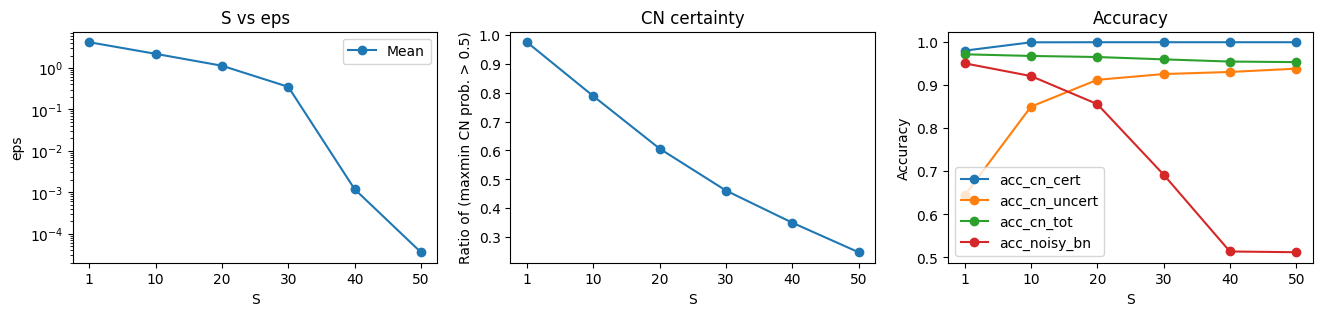

In [4]:
## Plots
fig, axes = plt.subplots(1, 3, figsize=(16,3))

# Ess vs eps
ax = axes[0]
eps_mean = np.array([x[0] for x in res["eps"]])
ax.semilogy(res["ess"], eps_mean, "-o", label="Mean")
ax.set_xlabel("S")
ax.set_ylabel("eps")
ax.set_title("S vs eps")
ax.legend(loc='best')

# Ess vs CN certainty
ax = axes[1]
ax.plot(res["ess"], res["cert_cn"], "-o")
ax.set_xlabel("S")
ax.set_ylabel("Ratio of (maxmin CN prob. > 0.5)")
ax.set_title("CN certainty")

# Accuracy
ax = axes[2]
labels = ["acc_noisy_bn", "acc_cn_tot", "acc_cn_cert", "acc_cn_uncert"]
for key in res.keys():
    if "acc" in key:
        ax.plot(res["ess"], res[key], "-o", label=key)
ax.set_xlabel("S")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax.legend(loc='best')

plt.show()

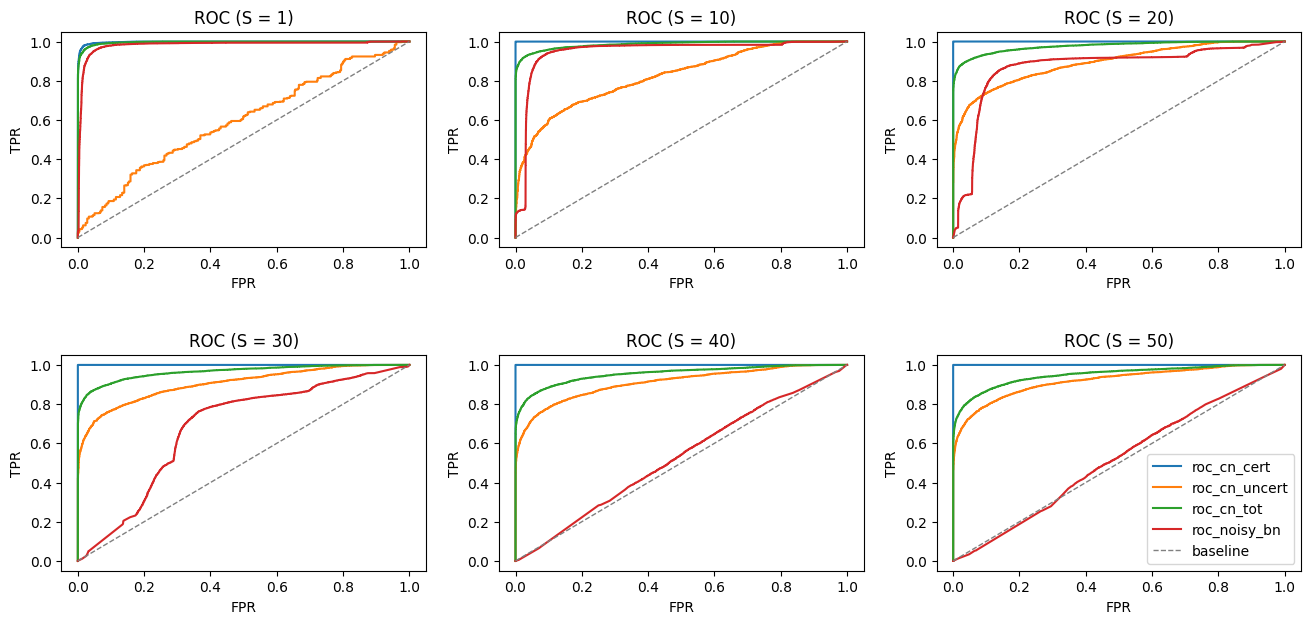

In [5]:
## ROC curves
fig, axes = plt.subplots(2, 3, figsize=(16,7))

i = 0
for ess in res["ess"]:
    ax = axes.flatten()[i]

    for key in roc.keys():
        fpr, tpr, _ = roc[key][ess]
        ax.plot(fpr, tpr, label=key)

    ax.plot([0,1], [0,1], color="gray", linestyle='dashed', linewidth=1, label="baseline")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"ROC (S = {ess})")

    i += 1

plt.legend(loc="best")
plt.subplots_adjust(hspace = .5)
plt.show()